# Calculating the horizontal Turner Angle

## Table Of Contents: <a class="anchor" id="top"></a>

* [Calculate Horizontal Turner Angle](#turner-angle)
* [Save & Upload monthly climatology TA](#saving-data)

# 1) Calculate Horizontal Turner Angle <a class='anchor' id='turner-angle'></a>
$$Tu_h = atan2(\frac{\nabla \rho}{|\nabla \rho|} \cdot (\alpha \nabla T + \beta \nabla S), \frac{\nabla \rho}{|\nabla \rho|} \cdot (\alpha \nabla T - \beta \nabla S))$$

(Turner 1973, [Ruddick 1983](https://reader.elsevier.com/reader/sd/pii/0198014983900638?token=65952EBCA83FAAF5BF2480348931B38611B7AD90A9E27A17537E663CAF25691DF01538E4A5516463CD6E5ED33649AEEB&originRegion=us-east-1&originCreation=20220706161949), [Johnson et al., 2012](http://dx.doi.org/10.1029/2011JC007651))

- The atan() and atan2() functions calculate the arctangent of x and y/x, respectively. 
- The atan() function returns a value in the range -π/2 to π/2 radians. The atan2() function returns a value in the range -π to π radians. If both arguments of the atan2() function are zero, the function sets errno to EDOM, and returns a value of 0.

_Expanded form_

$$Tu_h = atan2(\frac{1}{|\nabla \rho|}\{\frac{\partial \rho}{\partial x}  [\alpha \frac{\partial T}{\partial x} + \beta \frac{\partial S}{\partial x}] + \frac{\partial \rho}{\partial y}  [\alpha \frac{\partial T}{\partial y} + \beta \frac{\partial S}{\partial y}]\}, \frac{1}{|\nabla \rho|}\{\frac{\partial \rho}{\partial x}  [\alpha \frac{\partial T}{\partial x} - \beta \frac{\partial S}{\partial x}] + \frac{\partial \rho}{\partial y}  [\alpha \frac{\partial T}{\partial y} - \beta \frac{\partial S}{\partial y}]\})$$

where,

$$\frac{1}{|\nabla \rho|} = \frac{1}{\sqrt{(\frac{\partial \rho}{\partial x})^2 + (\frac{\partial \rho}{\partial y}})^2}$$

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.8e499707e68345248ab2bd2effde9d43/status,


In [42]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import json
import fsspec
import gcsfs
import xmitgcm
from xhistogram.xarray import histogram

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU']])

In [5]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds_drop)

In [26]:
def horizontal_turner_angle():
    """Compute horizontal turner angle given SST and SSS, 
        and user-defined basin selection"""
    
    def gradient(da):
        """Compute the gradients of T, S and rho"""
        
        da_diffx = grid.diff(da, 'X')
        da_diffy = grid.diff(da, 'Y', boundary='fill')
        da_diffx_interp = grid.interp(da_diffx, 'X')
        da_diffy_interp = grid.interp(da_diffy, 'Y', boundary='fill')
        dadx = da_diffx_interp/ds_ren.DXT
        dady = da_diffy_interp / ds_ren.DYT
        return dadx, dady
    
    #create grad-rho and |grad-rho| terms
    rho = fastjmd95.rho(ds_ren.SSS, ds_ren.SST, 0)
    #rho = xr.apply_ufunc(jmd95numba.rho, ds_ren.SSS, ds_ren.SST, 0,
                     #output_dtypes=ds_ren.SST.dtype,
                     #dask='parallelized', vectorize=True).reset_coords(drop=True)
    gradrho = gradient(rho)
    modgradrho = 1 / np.sqrt(gradrho[0]**2 + gradrho[-1]**2)
    
    #create gradT and gradS
    gradT = gradient(ds_ren.SST)
    gradS = gradient(ds_ren.SSS)
    
    #define alpha and beta
    runit2mass = 1.035e3 #rho_0
    drhodt = xr.apply_ufunc(fastjmd95.drhodt, ds_ren.SSS, ds_ren.SST, 0,
                        output_dtypes=[ds_ren.SST.dtype],
                        dask='parallelized', vectorize=True).reset_coords(drop=True)#.load()
    drhods = xr.apply_ufunc(fastjmd95.drhods, ds_ren.SSS, ds_ren.SST, 0,
                        output_dtypes=[ds_ren.SSS.dtype],
                        dask='parallelized', vectorize=True).reset_coords(drop=True)#.load()
    alpha = - drhodt / runit2mass
    beta = drhods / runit2mass
    
    #define eq
    #gradrho[0/1] is selecting the dadx/dady output from `gradient` func above
    term1 = modgradrho*(gradrho[0]*(alpha*gradT[0] + beta*gradS[0]) + gradrho[1]*(alpha*gradT[1] + beta*gradS[1]))
    term2 = modgradrho*(gradrho[0]*(alpha*gradT[0] - beta*gradS[0]) + gradrho[1]*(alpha*gradT[1] - beta*gradS[1]))
    turner_radians = np.arctan2(term1, term2)
    turner_angle = np.rad2deg(ta_rad)
    
    return (turner_radians)

In [7]:
#weddell region
selection = dict(time=10, nlon_t=slice(470, 1000), nlat_t=slice(0,500))

#### Plot Turner angle

In [23]:
ta = horizontal_turner_angle()

In [24]:
ta

<xarray.DataArray (time: 14965, nlat_t: 2400, nlon_t: 3600)>
dask.array<rad2deg, shape=(14965, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
    DXT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: time

In [36]:
ta_newcoord = ta.assign_coords(coords={'time':cesm.time})
ta_newcoord_drop = ta_newcoord.drop([v for v in ta_newcoord.coords if v not in ['nlon_t', 'nlat_t', 'time']])
ta_newcoord_drop

<xarray.DataArray (time: 14965, nlat_t: 2400, nlon_t: 3600)>
dask.array<rad2deg, shape=(14965, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00

In [38]:
ta_clim = ta_newcoord_drop.groupby('time.month').mean()
ta_clim

<xarray.DataArray (month: 12, nlat_t: 2400, nlon_t: 3600)>
dask.array<transpose, shape=(12, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [46]:
ta_clim.nbytes/1e9

0.82944

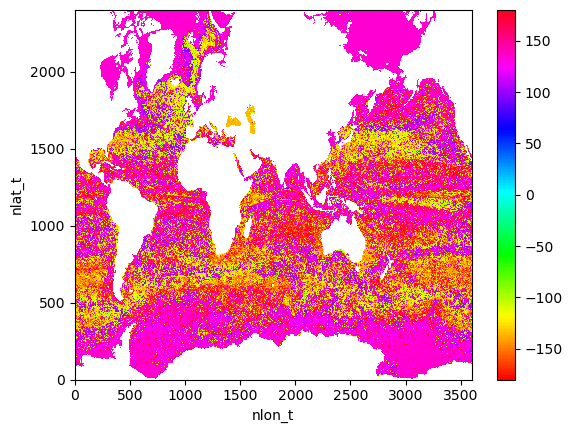

In [28]:
ta[10].plot(cmap='hsv')

In [44]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.8e499707e68345248ab2bd2effde9d43/status,


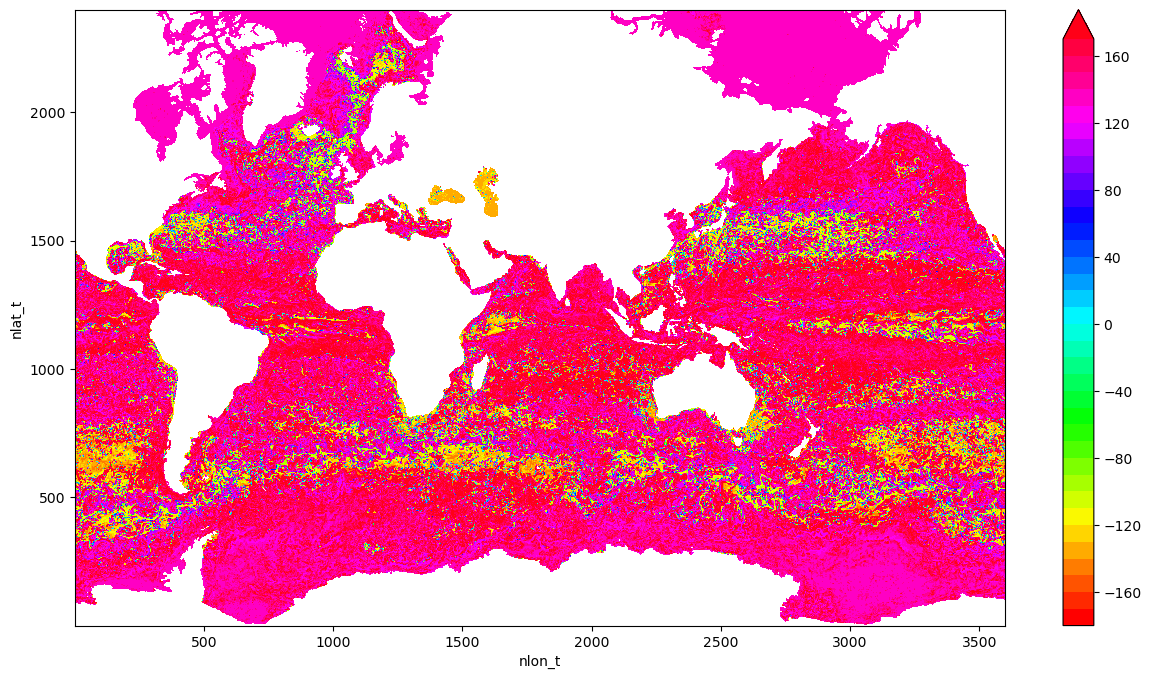

In [45]:
#global turner angle
fig, ax = plt.subplots(figsize=(15,8))
ta[10].plot.contourf(levels=np.arange(-180, 180, 10),  cmap='hsv', ax=ax);

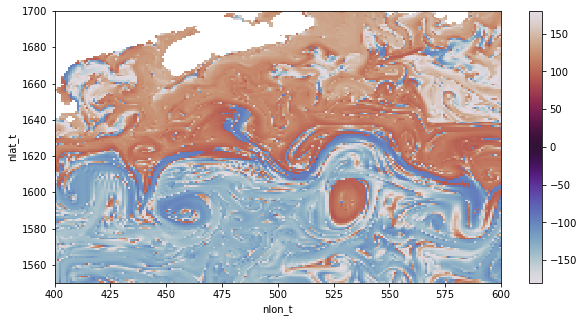

In [37]:
#Gulf stream
ta[10].isel(nlon_t=slice(400, 600), nlat_t=slice(1550, 1700)).plot(figsize=(10,5), cmap='twilight')

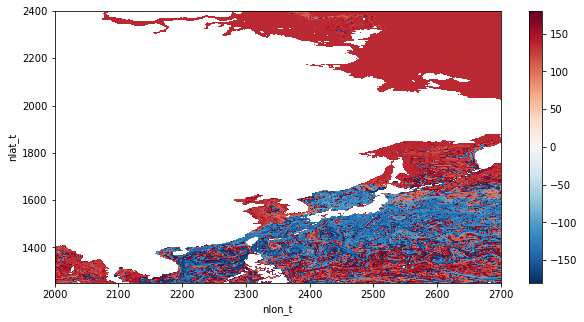

In [33]:
#russia's northwestern coast to compare with histogram subplts
ta_deg1[10].isel(nlon_t=slice(2000, 2700), nlat_t=slice(1250, 2400)).plot(figsize=(10,5))

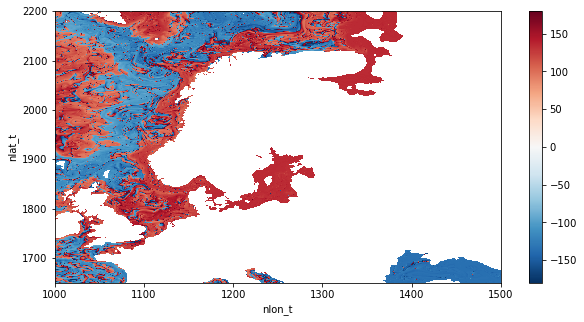

In [26]:
#mediterranean sea to compare with histogram subplots
ta_deg1[10].isel(nlon_t=slice(1000, 1500), nlat_t=slice(1650, 2200)).plot(figsize=(10,5))

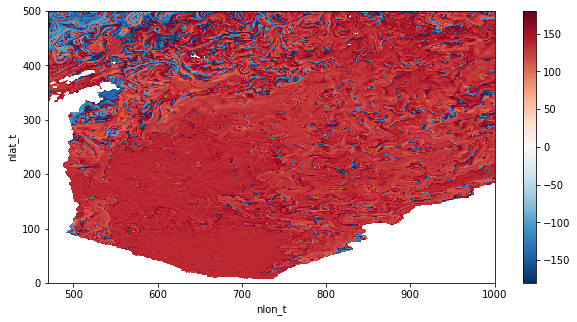

In [31]:
#weddell
ta_deg1.isel(**selection).plot(figsize=(10,5))

# Save & upload monthly climatology of TA <a class='anchor' id='saving-data'></a>

In [48]:
import json
with open('/home/jovyan/chapter2/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [52]:
ta_clim.to_dataset(name='ta_clim')

<xarray.Dataset>
Dimensions:  (nlon_t: 3600, nlat_t: 2400, month: 12)
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ta_clim  (month, nlat_t, nlon_t) float64 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [49]:
#saving monthly climatology histograms
gcsmap_ta = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/ta_clim.zarr')
ta_clim.to_zarr(gcsmap_ta, mode='w')

AttributeError: 'DataArray' object has no attribute 'to_zarr'

[Back to top](#top)